## Importações

In [114]:
import pandas as pd
from math import floor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from sklearn import tree

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import norm
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix,recall_score,precision_score

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import f_classif, f_oneway, chi2,mutual_info_classif 
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

## Funções Comuns

In [115]:
def funcPlotMatriz(y_test, classificar):
    matriz_de_confusao = confusion_matrix(y_test, classificar)
    sns.heatmap(matriz_de_confusao, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
    plt.show()


def funcMetricas(df_metricas,modelo_Versao, df,quant_columns,Hyper_Parametros,y_test, classificar):
    metricas = [
        modelo_Versao,
        df,
        quant_columns,
        Hyper_Parametros,
        accuracy_score(y_test, classificar), 
        round(recall_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(precision_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(f1_score(y_test, classificar, pos_label=0,average='macro'),2)
        ]
    
    nova_linha_df = pd.DataFrame([metricas], columns=df_metricas.columns)

    df_metricas = pd.concat([df_metricas, nova_linha_df], ignore_index=True)
    
    return df_metricas

def funcPlotDistribuicao(df):
    fig, axs = plt.subplots(int(np.ceil(len(df.columns) / 4)), 4, figsize=(20, 20))
    axs = axs.flatten()  # Aplanar a matriz de eixos para fácil indexação

    for i, col in enumerate(df.columns):
        # Plotar a distribuição da coluna com KDE
        sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
        
        mean = df[col].mean()
        std = df[col].std()
        
        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        y = norm.pdf(x, mean, std)
        
        axs[i].plot(x, y, color='r', linestyle='--')
        
        axs[i].set_title(f'Distribuição de {col}')

    for j in range(len(df.columns), len(axs)):
        fig.delaxes(axs[j])

    # Ajustar layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


## Extraindo a Base

In [116]:
df_original = pd.read_excel('..\dados\df_original.xlsx')

df = df_original.copy()

display(df)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III


### Dividindo o Dataframe em Valor Explicativo e Resposta

In [117]:
df_x ,df_y= df.iloc[:, :-1],df.iloc[:, -1]

df_y = pd.DataFrame(df_y)
display(df_x)
display(df_y)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation


,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II
...,...
2106,Obesity_Type_III
2107,Obesity_Type_III
2108,Obesity_Type_III
2109,Obesity_Type_III


### Transformando os Dados Qualitativos em Quantitativos

In [118]:
label_encolder = LabelEncoder()

preprocessador = ColumnTransformer(
    transformers=[
        ('categoria', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool']))
    ],
    remainder='passthrough',  # Mantém as outras colunas inalteradas
    verbose_feature_names_out=False,  # Mantém os nomes originais das colunas
    
)

# Ajustar e transformar o DataFrame usando o preprocessador
df_x_encoded = preprocessador.fit_transform(df_x)

df_y_encoded = label_encolder.fit_transform(df_y)

# Se necessário, converter o resultado de volta para um DataFrame, mantendo os nomes das colunas
df_x_encoded = pd.DataFrame(df_x_encoded, columns=preprocessador.get_feature_names_out())
# Matém a ordem do df original
df_x_encoded = df_x_encoded[df_x.columns]

df_y_encoded = pd.DataFrame(df_y_encoded, columns=df_y.columns)

# df_x_encoded=df_x_encoded[df_x.columns]

df_encoded = df_x_encoded.copy()
df_encoded['NObeyesdad']=df_y_encoded
df_encoded

display(df_x_encoded)
display(df_y_encoded)

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0.0,21.0,1.620000,64.000000,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,3.0
1,0.0,21.0,1.520000,56.000000,1.0,0.0,3.0,3.0,2.0,1.0,3.0,1.0,3.0,0.0,2.0,3.0
2,1.0,23.0,1.800000,77.000000,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,3.0
3,1.0,27.0,1.800000,87.000000,0.0,0.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,4.0
4,1.0,22.0,1.780000,89.800000,0.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,20.0,1.710730,131.408528,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,2.0,3.0
2107,0.0,21.0,1.748584,133.742943,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2108,0.0,22.0,1.752206,133.689352,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2109,0.0,24.0,1.739450,133.346641,1.0,1.0,3.0,3.0,2.0,0.0,3.0,0.0,1.0,1.0,2.0,3.0


,NObeyesdad
0,1
1,1
2,1
3,5
4,6
...,...
2106,4
2107,4
2108,4
2109,4


#### Dividindo os DataFrames de Teste e Treino

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_encoded, test_size=0.25,random_state=42,shuffle=True)

# Salva o array na memoria para guardar a ordem das colunas
# X_train = np.ascontiguousarray(X_train)
# X_test = np.ascontiguousarray(X_test)

## Modelo Decision Tree

### Teste Simples

In [120]:
modelo_decision_tree = tree.DecisionTreeClassifier(criterion='gini')

scores = cross_validate(modelo_decision_tree, X_train, y_train, cv=5, scoring=['accuracy','precision_macro','recall_macro','f1_macro'])
chaves = ['test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro']

scores_avg = [scores[chave].mean() for chave in chaves] 

print(scores)
print(scores_avg)


{'fit_time': array([0.01217079, 0.04178858, 0.00800395, 0.01341844, 0.00821447]), 'score_time': array([0.02568674, 0.04090619, 0.01929975, 0.01602459, 0.01399732]), 'test_accuracy': array([0.94006309, 0.94006309, 0.94006309, 0.92405063, 0.94936709]), 'test_precision_macro': array([0.94002501, 0.93921976, 0.94380897, 0.92737641, 0.94887986]), 'test_recall_macro': array([0.9395107 , 0.93737454, 0.93826015, 0.9218918 , 0.9471909 ]), 'test_f1_macro': array([0.93879272, 0.9377723 , 0.93918281, 0.92209576, 0.94772903])}
[0.9387213991933875, 0.9398620050223417, 0.9368456214328134, 0.9371145261104703]


In [121]:
modelo_decision_tree.fit(X_train, y_train)
classificar = modelo_decision_tree.predict(X_test)
print(classification_report(y_test,classificar))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        68
           1       0.85      0.81      0.83        78
           2       0.92      0.90      0.91        94
           3       0.92      0.95      0.93        75
           4       1.00      0.99      0.99        79
           5       0.87      0.87      0.87        71
           6       0.94      0.94      0.94        63

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528



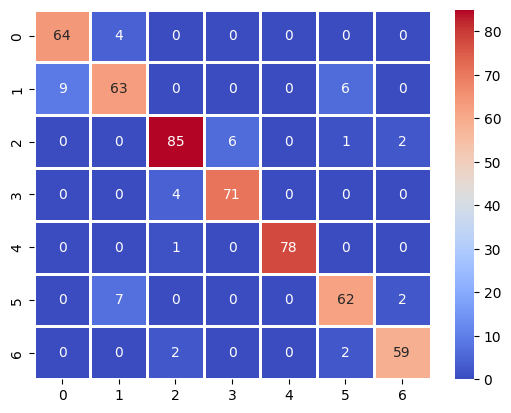

In [122]:
funcPlotMatriz(y_test, classificar)

### Entendendo o Resultado do Modelo

### Distribuição dos Dados

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now depre

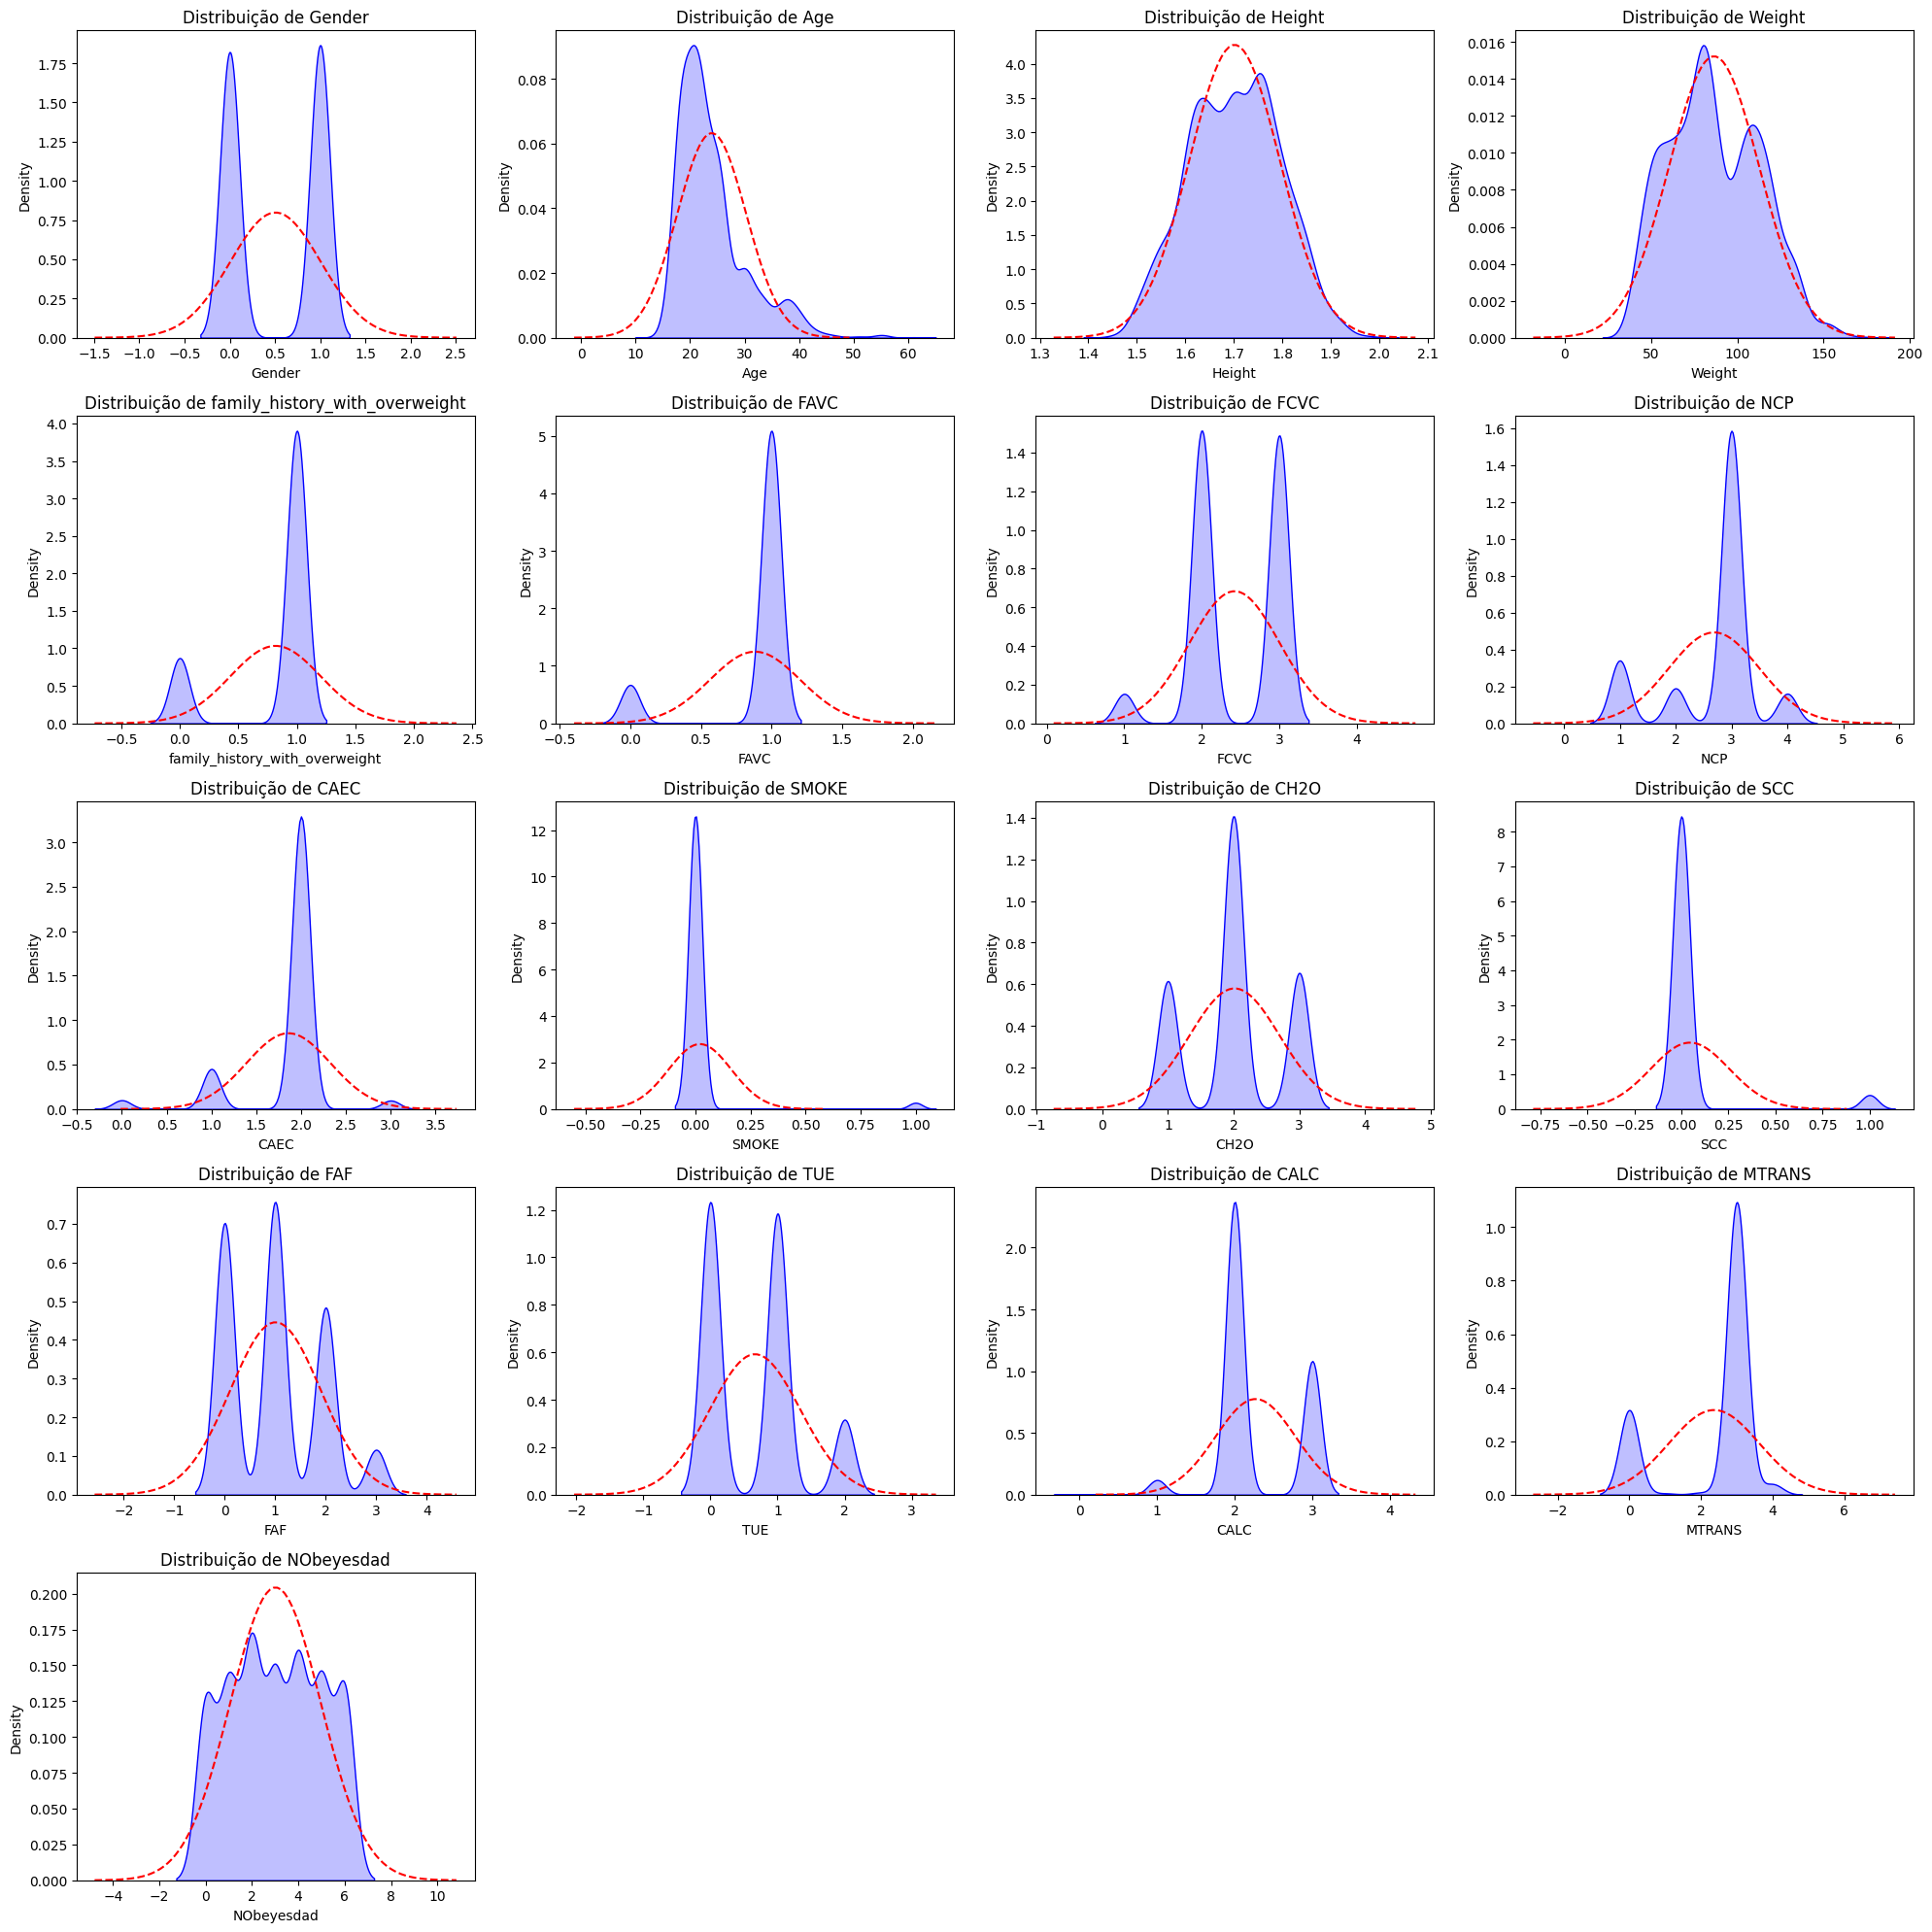

In [123]:
funcPlotDistribuicao(df_encoded)

O modelo Decision Tree trabalha bem com características bem descritivas e bem distribuídas, com classes balanceadas.

Podemos ver que possuímos muitas colunas, o que traz características suficientes para descrever adequadamente as classes resposta. Os dados estão bem distribuídos, mas as classes descritivas não estão balanceadas. Porém, os resultados iniciais são tão impressionantes que as classes que não estão tão bem balanceadas provavelmente contribuem muito bem para o modelo atuar.

Por isso, é muito importante levar em consideração a teoria, mas não ignorar a prática, por conta dos modelos de IA serem empíricos.

### Maldição da Dimensionalidade

In [124]:
len(df_x.columns)


16

Outro fator que pode estar prejudicando o desempenho do modelo é a alta quantidade de dimensões (colunas). Esse problema é denominado "Maldição da Dimensionalidade", termo introduzido pelo matemático R. Bellman, que se refere ao problema causado pelo aumento exponencial no volume associado à adição de dimensões extras a um espaço matemático.

Por exemplo:

Se dividirmos uma região do espaço em células regulares, o número de células cresce exponencialmente com a dimensão do espaço. Vamos denominar a dimensão como 
𝐷 e as células como 𝑁.


Se tivermos uma dimensão 𝐷1, com um número qualquer de células como 𝑁:


Ao aumentarmos uma dimensão, passando a ter 𝐷2, precisaremos ter o número de células como 𝑁^2.


Assim como 𝐷3 passaria a ter 𝑁^3, e assim por diante.


O que quero dizer é que, para um número qualquer de dimensões, é necessário ter a quantidade certa de amostras de dados. Isso nos leva a pensar que essa quantidade de amostras pode ser insuficiente ou excedente para essa quantidade de dimensões.

Algumas imagens que ilustram a explicação:

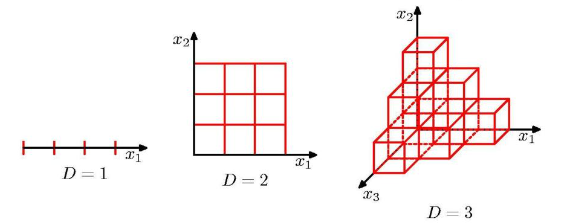

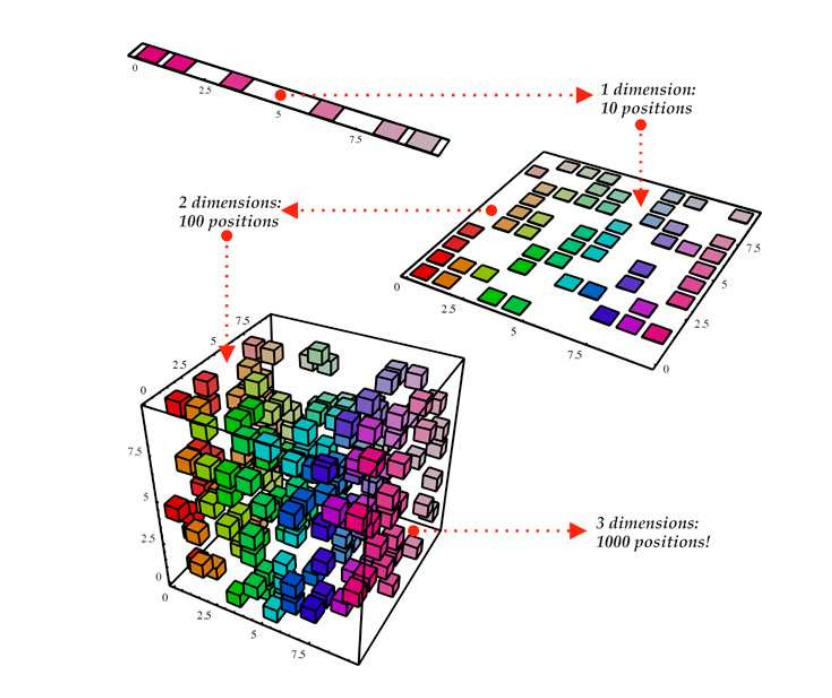

O modelo de Árvore de Decisão (Decision Tree) possui nós que representam testes ou decisões baseados nos atributos (características) dos dados. Os resultados do modelo podem ser muito afetados por colunas irrelevantes ou redundantes, o que dificulta a interpretação geral dos dados. Portanto, reduzir a dimensionalidade pode ajudar a destacar as características mais relevantes, melhorando a performance e a interpretabilidade do modelo.

### Distribuição das Classes Resposta

Iremos verificar a distribuição das classes, por conta do Decision Tree se comportar mal com classes desbalanceadas. Ele tende a priorizar as classes majoritárias e pode ter dificuldade em prever corretamente as classes minoritárias.

In [125]:
display(df_y_encoded.value_counts())
display(y_train.value_counts())
display(y_test.value_counts())

NObeyesdad
2             351
4             324
3             297
5             290
6             290
1             287
0             272
dtype: int64

NObeyesdad
2             257
4             245
6             227
3             222
5             219
1             209
0             204
dtype: int64

NObeyesdad
2             94
4             79
1             78
3             75
5             71
0             68
6             63
dtype: int64

As classes resposta estão bem balanceadas, sem mostrar grandes disparidades

## Teste do Modelo Embasado Nos Resultados Anteriores e em Obter o Melhor Desempenho Possível do Modelo

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

### Importando e Tratando Todas as Bases Alterádas em Análise Axploratória

In [127]:
lista_df = [] # Lista para armazenar os dfs

In [128]:
lista_df.append(df)

df_capping = pd.read_excel('..\dados\df_capping.xlsx')
display(df_capping.head(2))
lista_df.append(df_capping)

df_iqr = pd.read_excel('..\dados\df_iqr.xlsx')
display(df_iqr.head(2))
lista_df.append(df_iqr)

df_log = pd.read_excel('..\dados\df_log.xlsx')
display(df_log.head(2))
lista_df.append(df_log)

df_raiz = pd.read_excel('..\dados\df_raiz.xlsx')
display(df_raiz.head(2))
lista_df.append(df_raiz)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,3.091042,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,3.091042,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,4.582576,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,4.582576,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


In [129]:
df_capping.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [130]:
for k,v in enumerate(lista_df):
    ordem_colunas = lista_df[k].columns
    lista_df[k] = preprocessador.fit_transform(v)
    lista_df[k] = pd.DataFrame(lista_df[k], columns=preprocessador.get_feature_names_out())
    lista_df[k] = lista_df[k][ordem_colunas]


### PIPELINE

In [131]:
tree.DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Esta pipeline será utilizada para, organizar os passos de transformação de dados e para tentar aplicar o melhor modelo possivel nas condições do nosso caso. Além disso, ela também é muito util para replicar o processo em outros modelos. 

### Explicação da Pipeline

- "df_metricas" -> DataFrame que armazena o nome do modelo, o DataFrame utilizado, as métricas de teste e a melhor combinação de hiperparâmetros encontrada.
  
- "pipe" -> Variável que armazena todos os processos que compõem a pipeline.
    - `StandardScaler` -> Centraliza os dados em torno de zero, subtraindo a média de cada coluna e dividindo pelo desvio padrão, normalizando a dispersão dos dados.
    - `SelectKBest` -> Seleciona as features mais importantes da base de dados, auxiliando na redução de dimensionalidade. Utilizo esse método para reduzir o número de perguntas que serão feitas ao usuário, de 16 para, no máximo, 10.
    - `PCA` -> Reduz a dimensionalidade após o SelectKBest, preservando o máximo de variância nos dados.
    - `DecisionTreeClassifier` -> Modelo de machine learning utilizado após a redução de dimensionalidade.

- "params_pipe" -> Lista de parâmetros que serão testados na pipeline.
    - `SelectKBest__k` e `pca__n_components` -> Definem o número de colunas a serem mantidas na redução dimensional.
    - `SelectKBest__score_func` -> Funções de avaliação usadas para selecionar as colunas mais relevantes.
    - `model__criterion` ->  Defini a função de medida da impureza ou do ganho de informação durante o processo de construção da árvore. Ele controla como a árvore de decisão decide os melhores splits (divisões) nos dados, ou seja, como ela seleciona as variáveis e os valores nos nós que irão dividir os dados da maneira mais informativa.    
    - `model__ccp_alpha` -> Representa o parâmetro de Complexity Pruning Minimal Cost-Complexity (Poda de Complexidade Mínima). É usado para controlar o processo de poda da árvore, que visa reduzir o overfitting removendo ramos que têm pouca importância.
    - `model__splitter` -> Determina a estratégia usada para escolher a divisão em cada nó. Podendo avaliar todos os atributos e todos os possíveis pontos de corte para encontrar a melhor divisão, ou, avalia uma seleção aleatória de atributos em cada nó.

- "valores_k" -> Define o número máximo de colunas a serem selecionadas (até 10) pelo SelectKBest.

- GridSearchCV -> Executa a pipeline com diferentes combinações de hiperparâmetros, realiza validação cruzada e encontra a combinação que otimiza a acurácia.

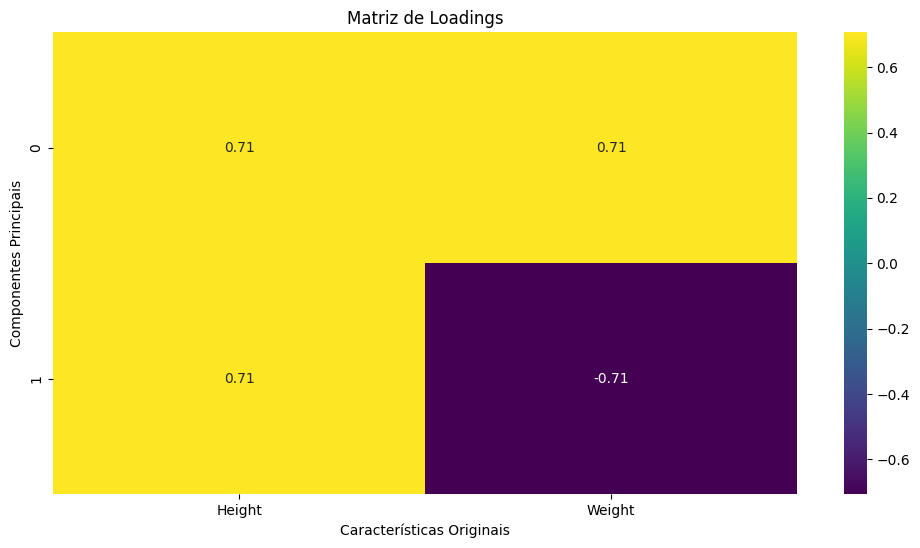

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])


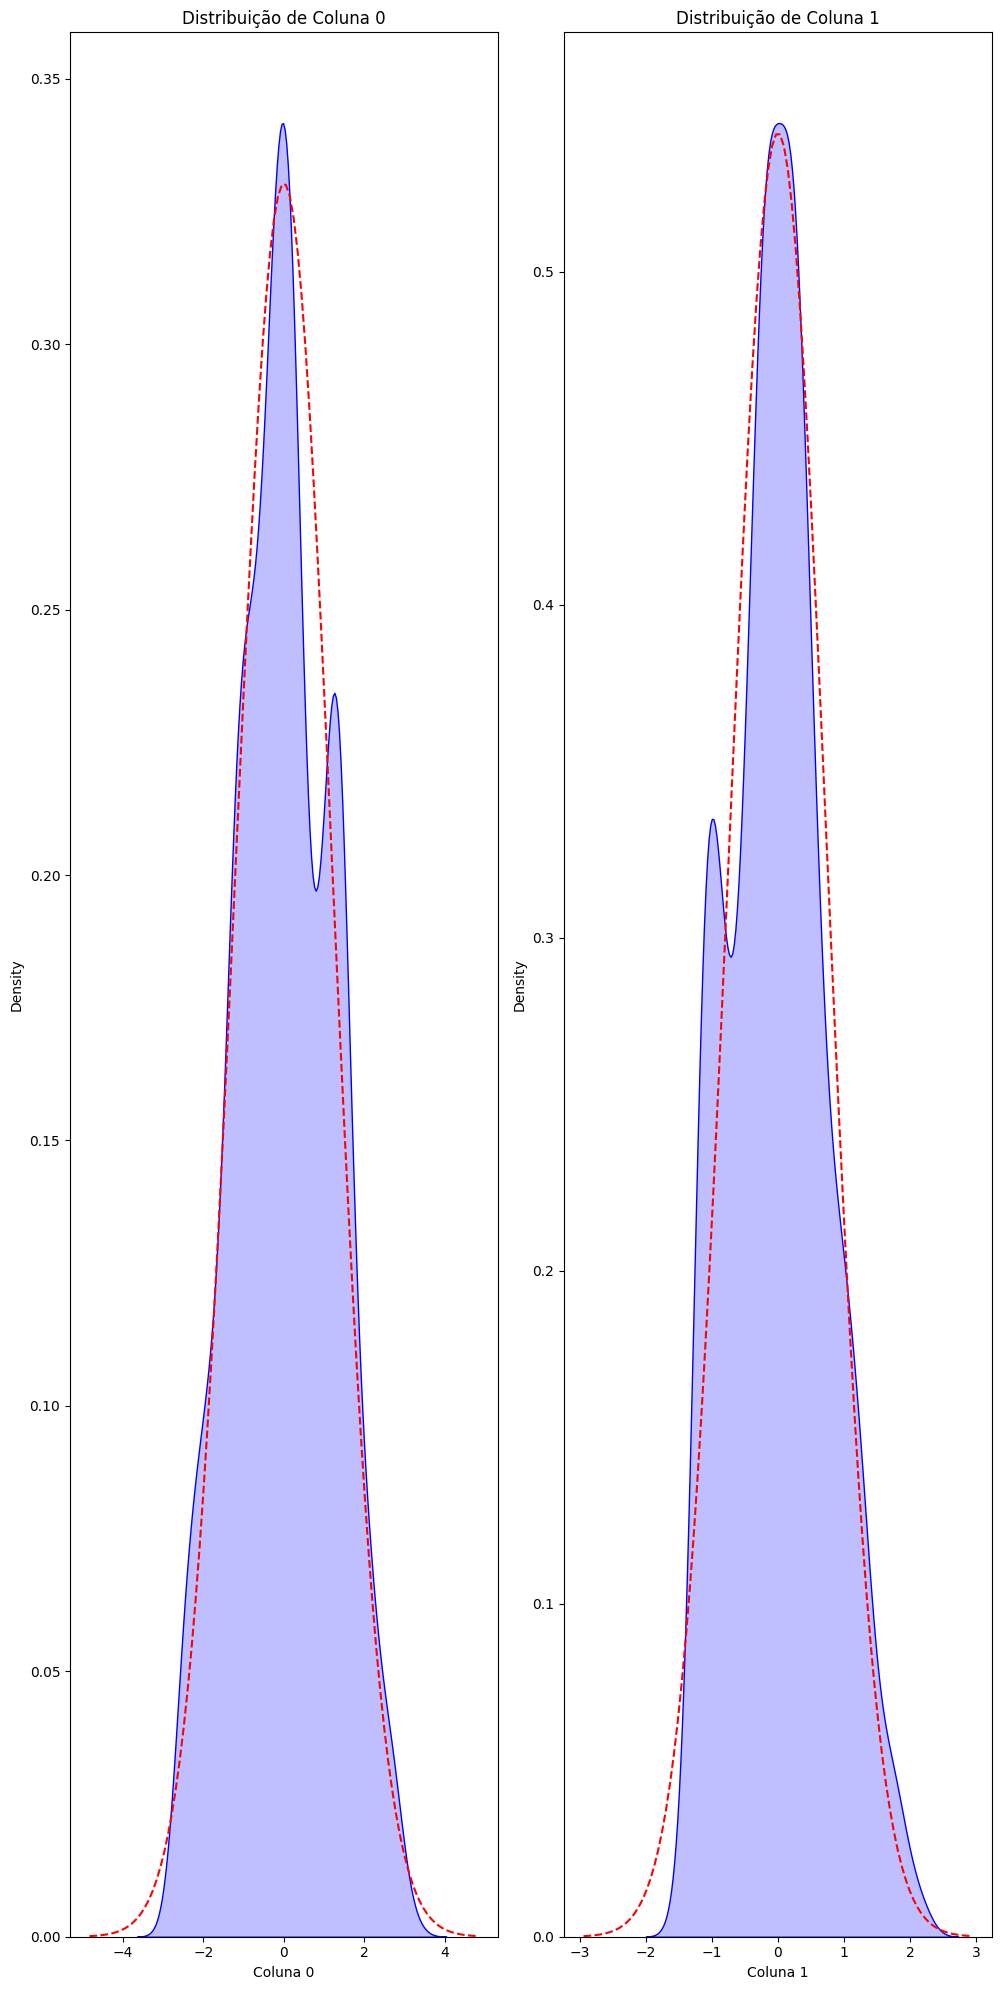

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x00000176C11E7C40>, 'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__splitter': 'random', 'pca__n_components': 2}
Melhor accuracy:  0.9166134249091563
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        68
         1.0       0.89      0.87      0.88        78
         2.0       0.96      0.94      0.95        94
         3.0       0.93      0.95      0.94        75
         4.0       0.97      0.97      0.97        79
         5.0       0.81      0.87      0.84        71
         6.0       0.85      0.81      0.83        63

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528



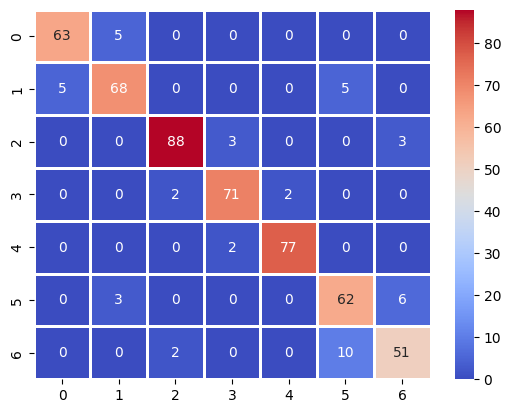

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


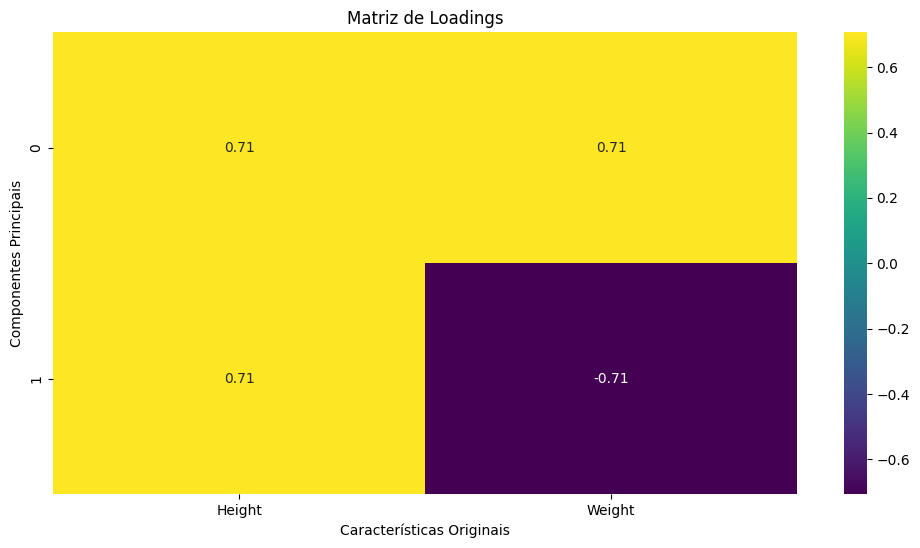

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])


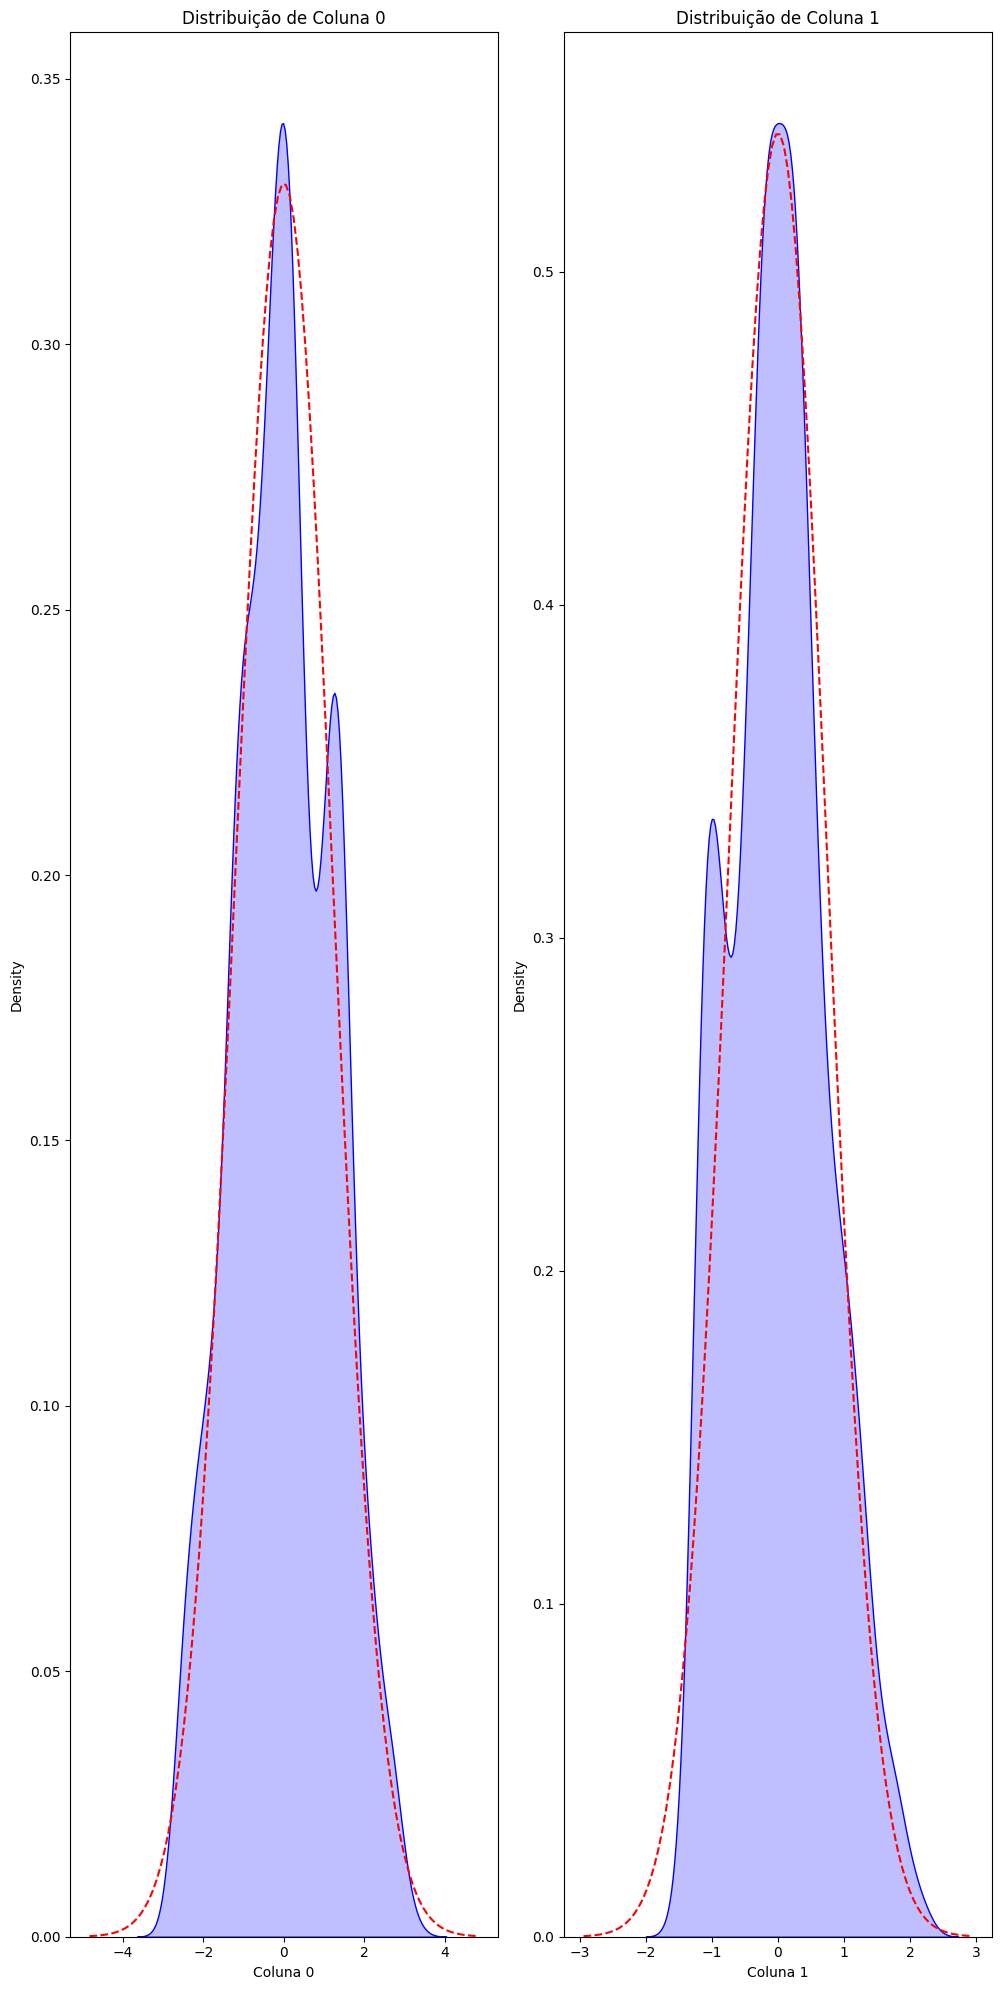

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x00000176C11E7C40>, 'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__splitter': 'random', 'pca__n_components': 2}
Melhor accuracy:  0.9166134249091563
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        68
         1.0       0.89      0.87      0.88        78
         2.0       0.96      0.94      0.95        94
         3.0       0.93      0.95      0.94        75
         4.0       0.97      0.97      0.97        79
         5.0       0.81      0.87      0.84        71
         6.0       0.85      0.81      0.83        63

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528



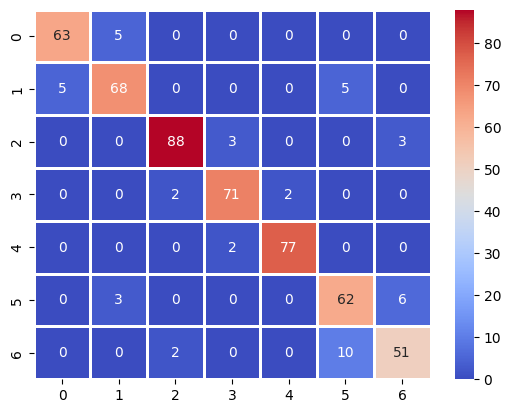

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


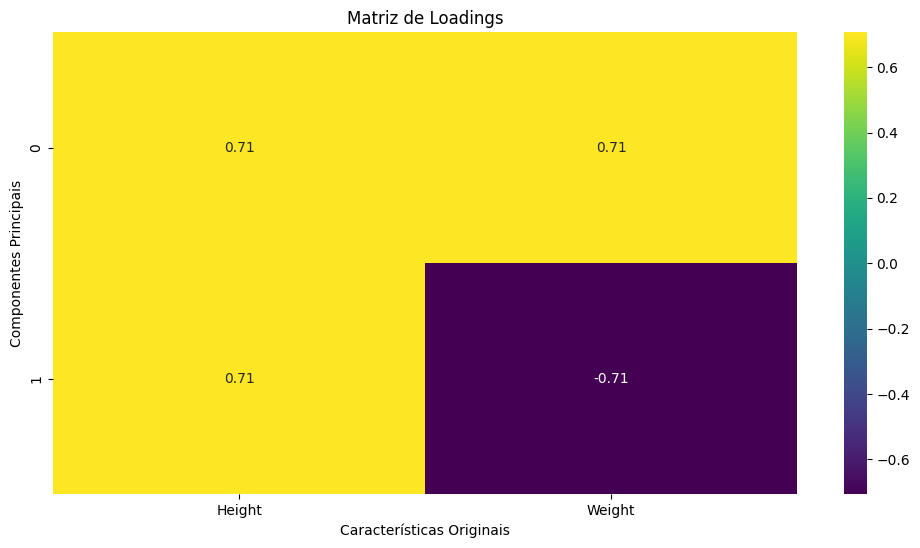

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])


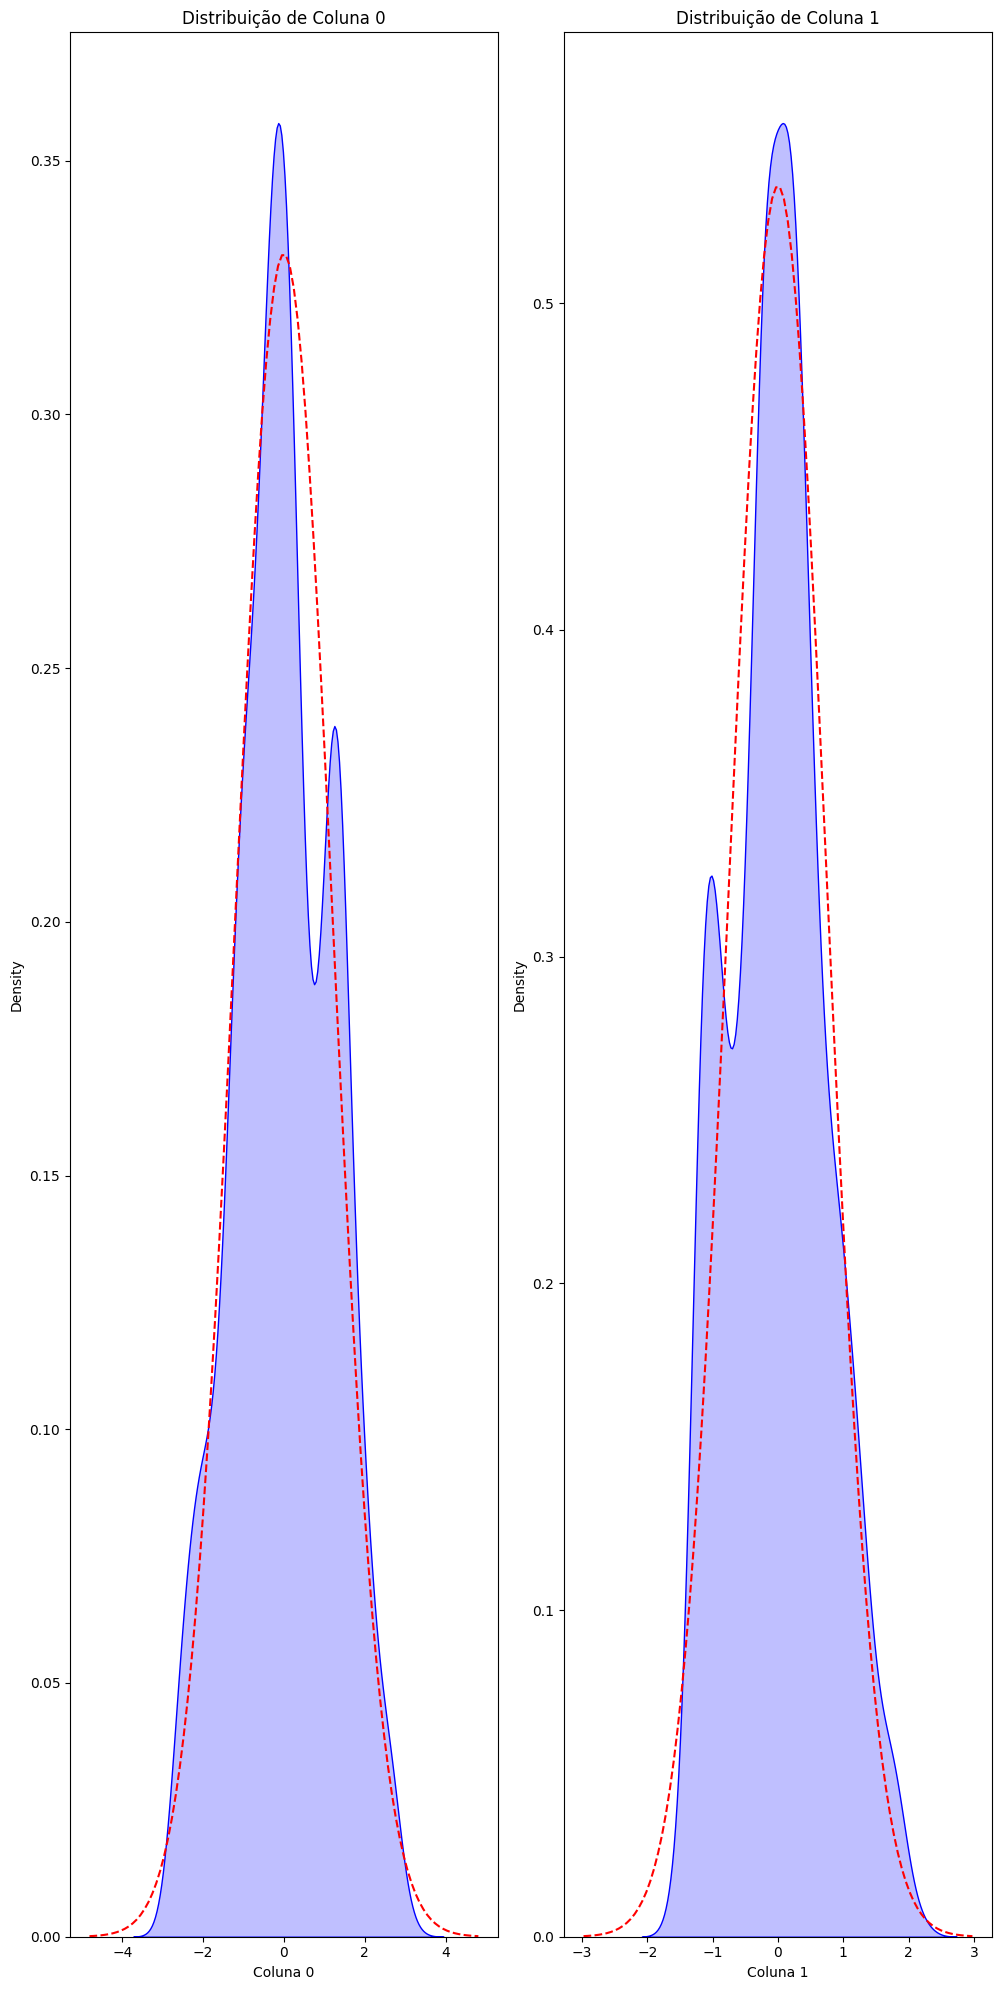

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x00000176C11E7C40>, 'model__ccp_alpha': 0.0010526315789473684, 'model__criterion': 'entropy', 'model__splitter': 'random', 'pca__n_components': 2}
Melhor accuracy:  0.9164971751412431
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96        85
         1.0       0.89      0.93      0.91        70
         2.0       0.96      0.97      0.96        70
         3.0       0.90      0.94      0.92        64
         4.0       0.99      0.94      0.96        79
         5.0       0.86      0.85      0.85        66
         6.0       0.88      0.91      0.90        57

    accuracy                           0.93       491
   macro avg       0.92      0.93      0.92       491
weighted avg       0.93      0.93      0.93       491



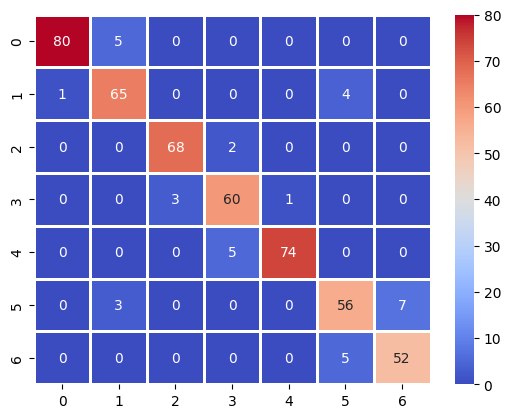

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


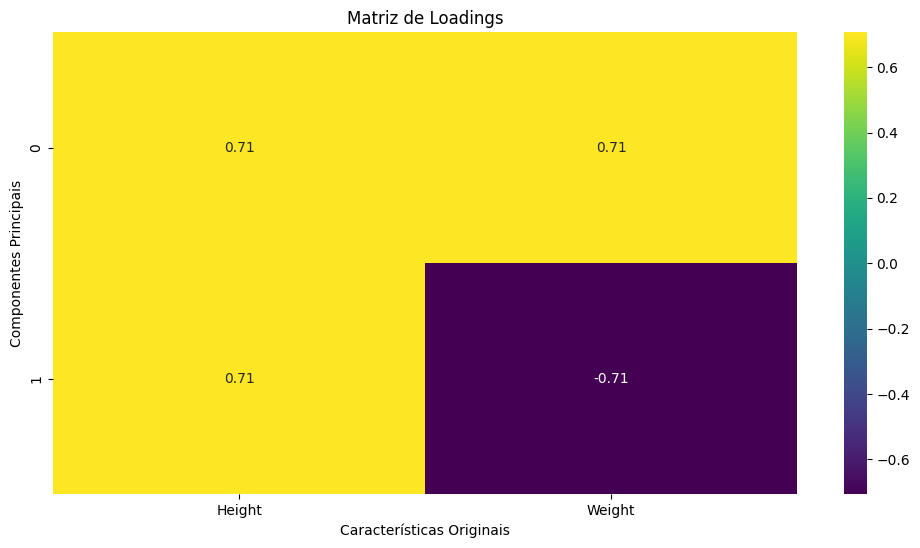

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])


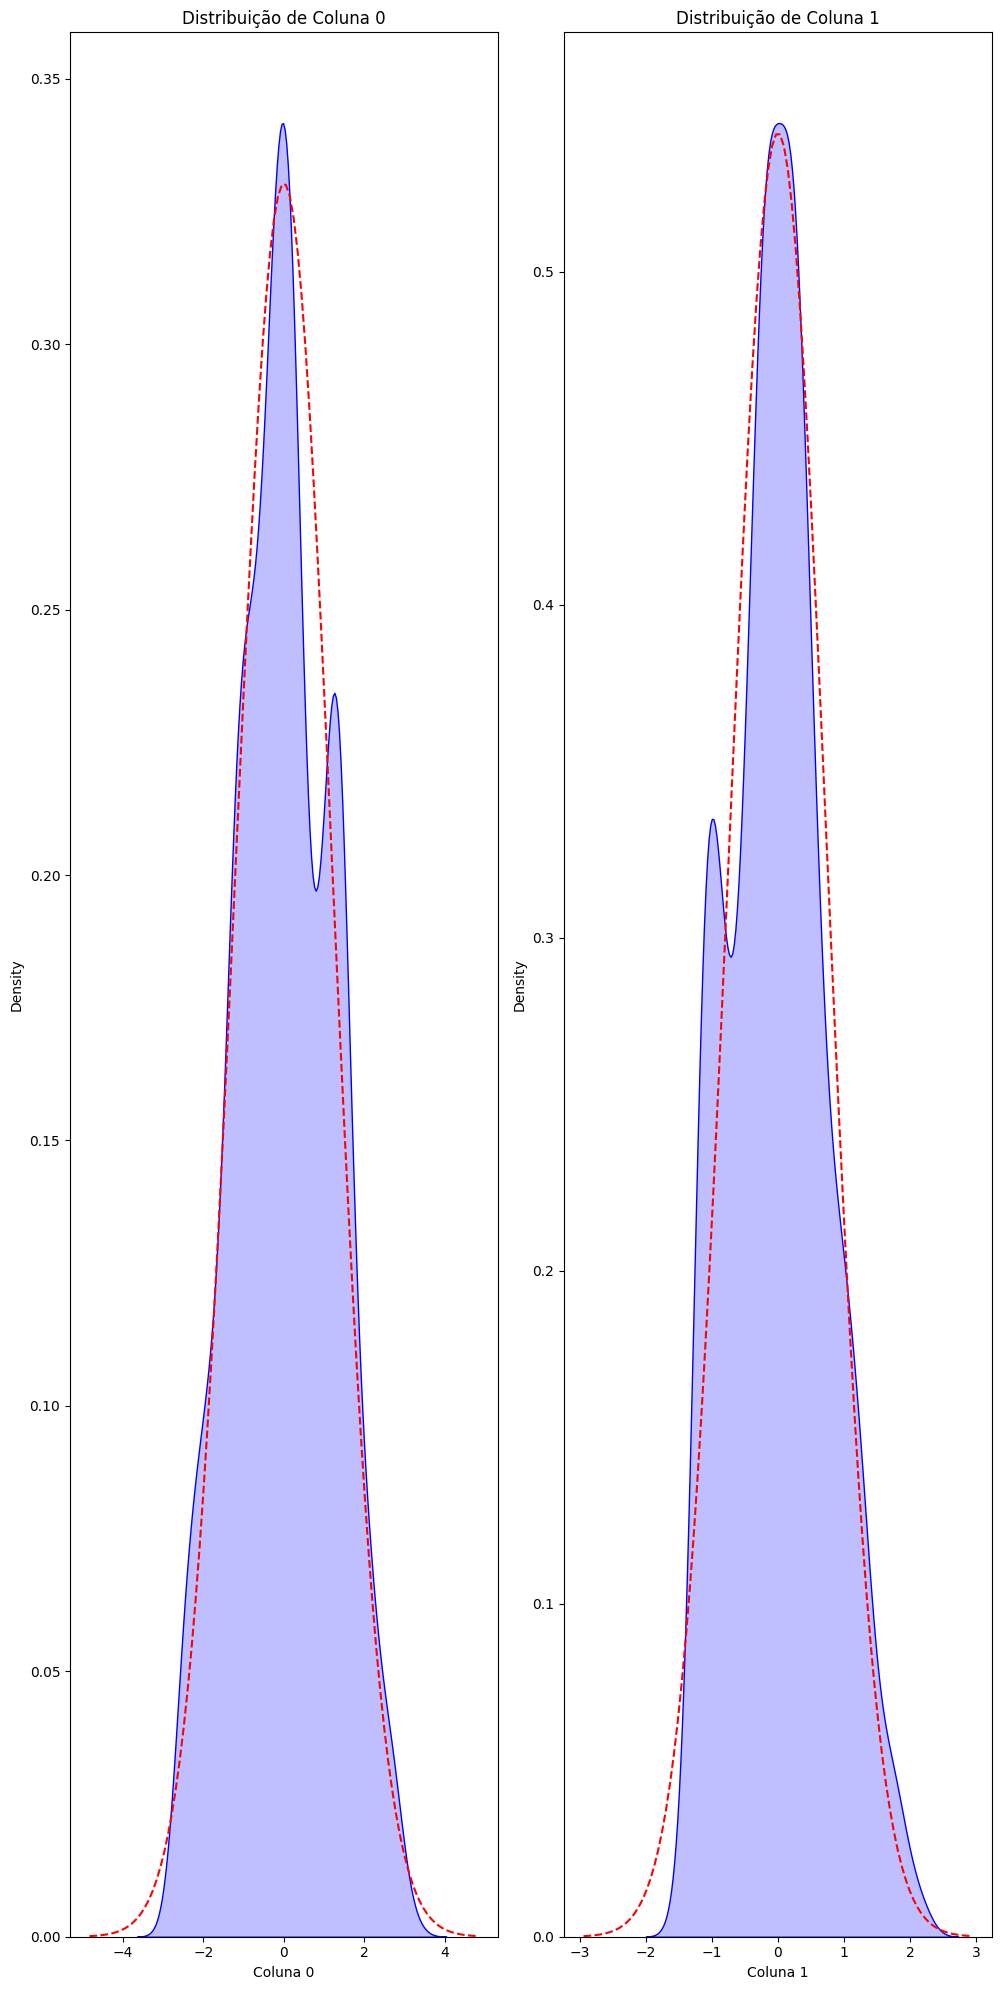

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x00000176C11E7C40>, 'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__splitter': 'random', 'pca__n_components': 2}
Melhor accuracy:  0.9166134249091563
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        68
         1.0       0.89      0.87      0.88        78
         2.0       0.96      0.94      0.95        94
         3.0       0.93      0.95      0.94        75
         4.0       0.97      0.97      0.97        79
         5.0       0.81      0.87      0.84        71
         6.0       0.85      0.81      0.83        63

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528



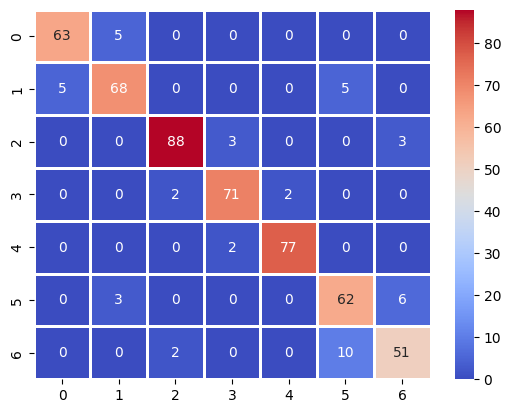

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


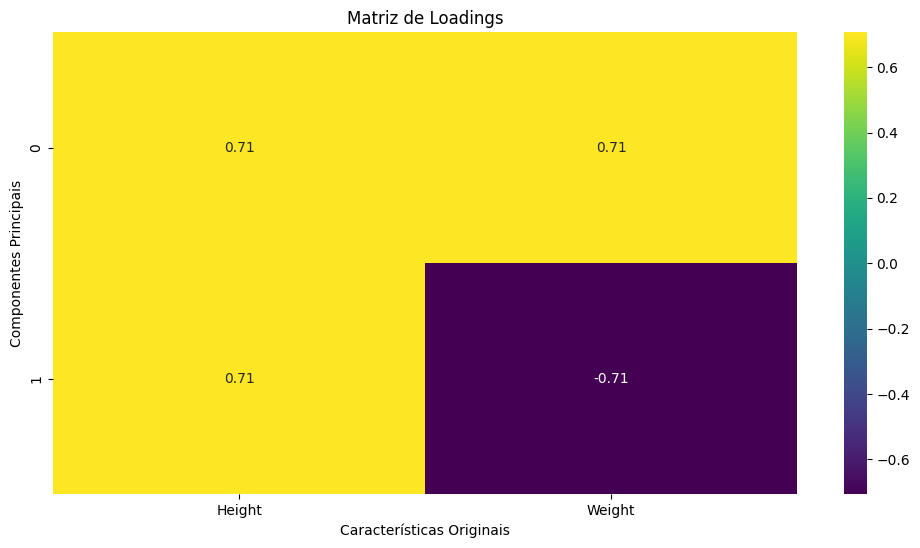

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_27860\2419017527.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], shade=True, color="b", ax=axs[i])


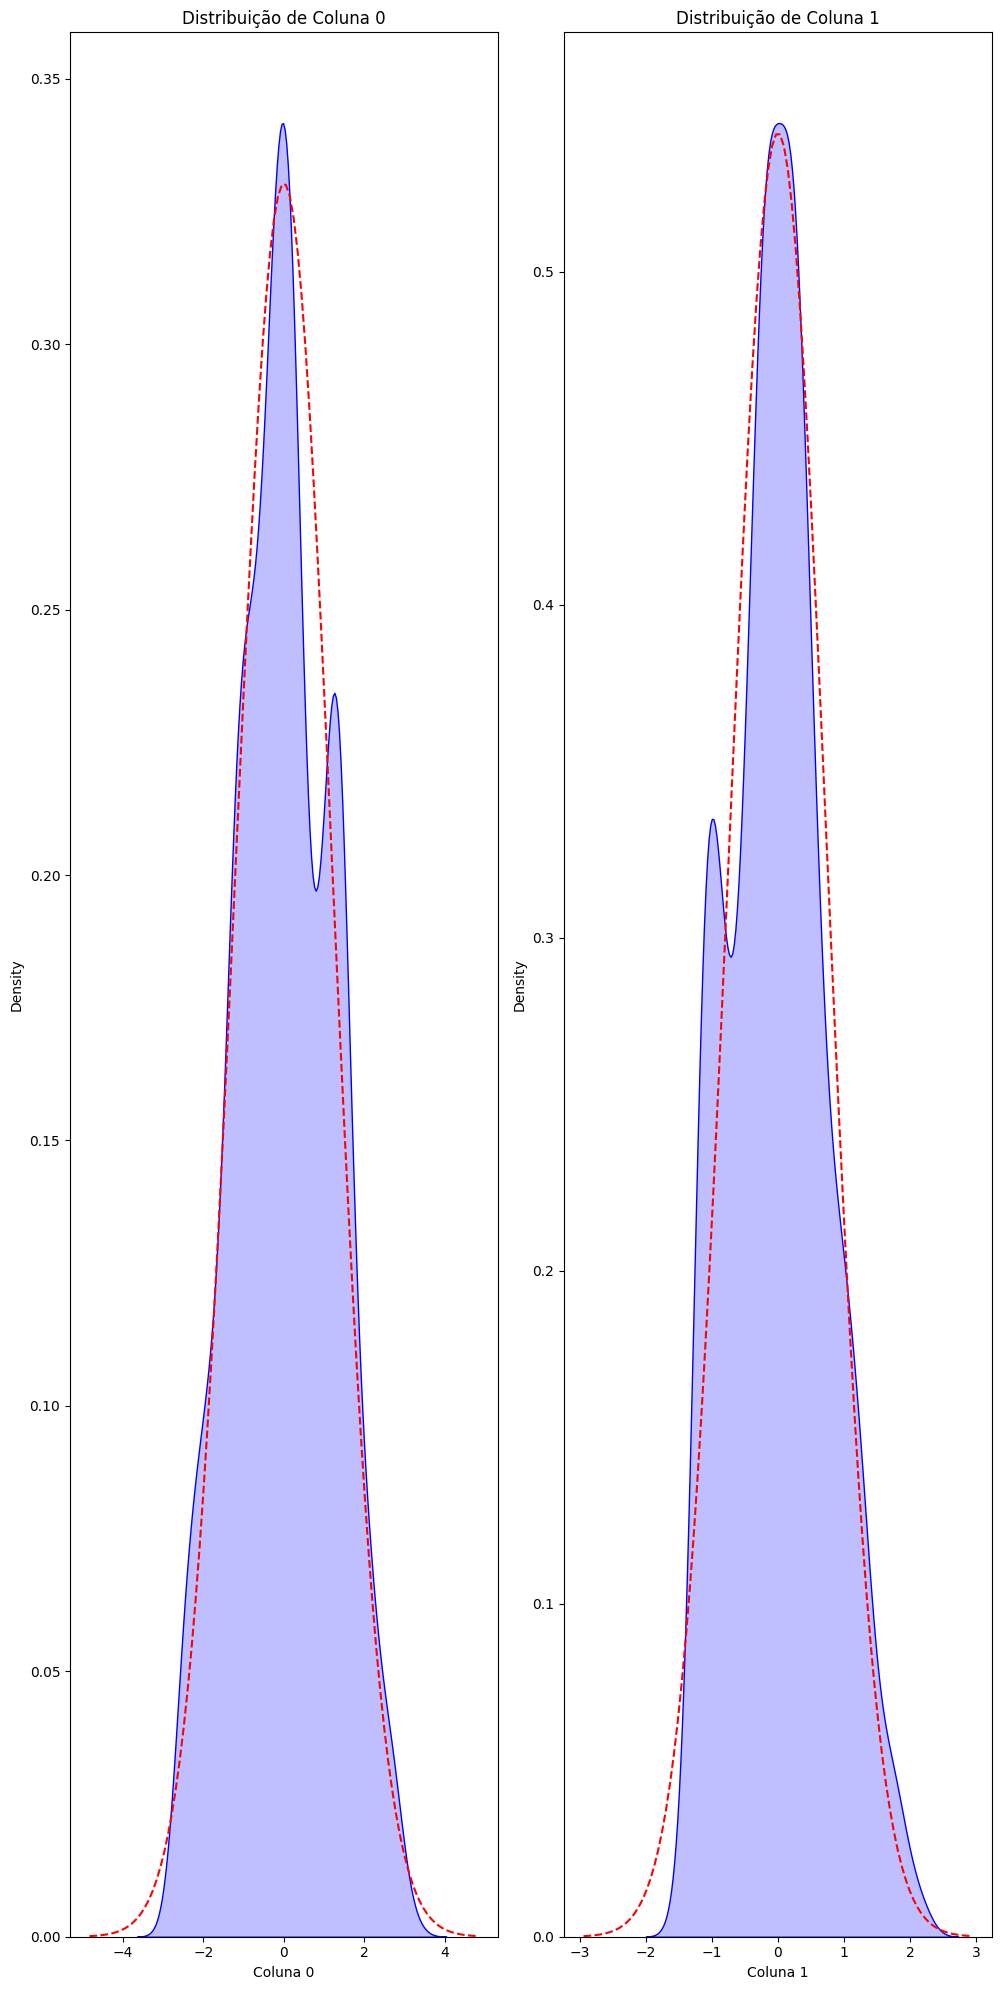

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x00000176C11E7C40>, 'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__splitter': 'random', 'pca__n_components': 2}
Melhor accuracy:  0.9166134249091563
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        68
         1.0       0.89      0.87      0.88        78
         2.0       0.96      0.94      0.95        94
         3.0       0.93      0.95      0.94        75
         4.0       0.97      0.97      0.97        79
         5.0       0.81      0.87      0.84        71
         6.0       0.85      0.81      0.83        63

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528



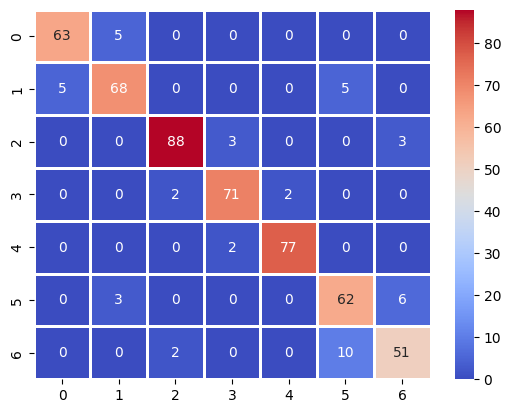

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,Modelo,DF,Quant_columns,Hyper_Parametros,Acuracia,Recall_Media,Precision_Media,F1_Score_Media
0,DecisionTree,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91
1,DecisionTree,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91
2,DecisionTree,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.926680,0.93,0.92,0.92
3,DecisionTree,Gender Age Height Weight ...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91
4,DecisionTree,Gender Age Height Weight ...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91


In [132]:
df_metricas = pd.DataFrame(columns=['Modelo','DF','Quant_columns','Hyper_Parametros','Acuracia','Recall_Media', 'Precision_Media', 'F1_Score_Media'])

for data_frame in lista_df:
    X_train, X_test, y_train, y_test = train_test_split(data_frame[data_frame.columns[:-1]], data_frame['NObeyesdad'], test_size=0.25,random_state=42,shuffle=True)
    
    # Pipeline
    pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('SelectKBest', SelectKBest()),
                ('pca', PCA()),
                ('model', tree.DecisionTreeClassifier(random_state=42))
                ])
    

    params_pipe = []
    valores_k = range(1, 11)

    for k in valores_k:
        for n in range(1, k + 1):
    
            params_pipe.append({
                'SelectKBest__k': [k],
                'pca__n_components': [n],
                'SelectKBest__score_func':[f_classif,f_oneway,mutual_info_classif],
                'model__criterion': ['gini','entropy','log_loss'],
                'model__ccp_alpha': np.linspace(0, 0.02, 20).tolist(),
                'model__splitter': ['best','random'],
            })

    # GridSearchCV
    grid_search = GridSearchCV(estimator = pipe,param_grid=params_pipe,n_jobs=-1,scoring='accuracy')

    grid_search.fit(X_train,y_train)

    # Pegando informações do GridSearchCV
    pca =grid_search.best_estimator_.named_steps['pca']
    kBest = grid_search.best_estimator_.named_steps['SelectKBest']
    melhor = grid_search.best_params_
    classificador_grafico = grid_search.best_estimator_

    components_df = pd.DataFrame(pca.components_, columns=data_frame.columns[kBest.get_support(indices=True).tolist()])

    # Extraindo apenas os transformadores (excluindo o modelo)
    pipeline_transformadores = classificador_grafico[:-1]
    # Transformando os dados de treinamento
    X_train_transformado = pipeline_transformadores.transform(X_train)
    # Obtendo o número de componentes após o PCA
    num_componentes = classificador_grafico.named_steps['pca'].n_components_
    # Criando nomes para os componentes principais
    nomes_componentes = [f'Coluna {i}' for i in range(num_componentes)]
    # Convertendo o array transformado em um DataFrame
    df_pipeline = pd.DataFrame(X_train_transformado, columns=nomes_componentes)


    # Plotagem
    plt.figure(figsize=(12, 6))
    sns.heatmap(components_df, cmap='viridis', annot=True)
    plt.xlabel('Características Originais')
    plt.ylabel('Componentes Principais')
    plt.title('Matriz de Loadings')
    plt.show()
    
    funcPlotDistribuicao(df_pipeline)

    # Analisando os resultados 
    print("Melhores parametros: ",melhor)
    print("Melhor accuracy: ",grid_search.best_score_)
    previsao = classificador_grafico.predict(X_test)
    metricas = classification_report(y_test,previsao)
    print(metricas)
    funcPlotMatriz(y_test, previsao)
    df_metricas = funcMetricas(df_metricas,'DecisionTree',data_frame,len(pca.components_),melhor,y_test,previsao)

display(df_metricas)        

### Algumas Conclusões

O modelo manteve um ótimo desempenho, com precisão, recall e acurácia altas.

Outras conclusões que podem ser tiradas são que as colunas selecionadas, que tiveram o melhor desempenho na validação cruzada (Cross-Validation), foram apenas:

Height
Weight
Resultado peculiar, considerando que a base tem 16 colunas e o modelo acaba possuindo o melhor resultado com apenas 2 colunas para se basear. Porém, a escolha dessas colunas faz muito sentido, por conta da relação peso por altura (IMC) descrever bem casos de sobrepeso e desnutrição.

Além disso, podemos perceber que todos os processos realizados com a base de dados acabaram deixando a base final com as duas colunas selecionadas com uma distribuição normal quase que perfeita, assim contribuindo muito para o bom desempenho do modelo e muito provavelmente conseguindo compensar as outras características que foram retiradas.

Concluindo, o resultado do modelo está muito bom, conseguindo predizer bem todas as 7 classes de resposta.

In [133]:
df_metricas

,Modelo,DF,Quant_columns,Hyper_Parametros,Acuracia,Recall_Media,Precision_Media,F1_Score_Media
0,DecisionTree,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91
1,DecisionTree,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91
2,DecisionTree,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.926680,0.93,0.92,0.92
3,DecisionTree,Gender Age Height Weight ...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91
4,DecisionTree,Gender Age Height Weight ...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.909091,0.91,0.91,0.91


In [134]:
df_metricas.to_excel('..\comparacao_modelos\DataFrames\df_decision_tree.xlsx')
                     